# Implementation and verification of Subspace IES

Test SIES for $p<n$ and inspect if Eq. 28 in Evensen 2019 is problematic.

We employ the deterministic non-linear forward model $y=g(x)=x_1+\beta x_2^3$ from example 5.1 made two dimensional.
We set ensemble size $n>2$ so to force Eq. 28 as $g$ is non-linear.

In [51]:
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams.update({'font.size': 14})
develop = False
plt.rcParams['text.usetex'] = True

import itertools

from typing import Callable
import numpy.typing as npt

# Implementation

We implement **Algorithm 1** from Evensen 2019, but with the option that Eq. 28 can be employed to project $\bf{Y}$ in line 4 of the pseudo-algorithm, if $g$ is linear and parameter size is smaller than ensemble size.

In [150]:
def subspace_ies(
    X: npt.NDArray[np.double], 
    D: npt.NDArray[np.double],
    g: Callable[[npt.NDArray[np.double]], float],
    linear: bool = False,
    step_size: float = 0.3, 
    iterations: int = 2
) -> npt.NDArray[np.double]:
    """Updates ensemble of parameters according to the Subspace 
    Iterative Ensemble Smoother (Evensen 2019).
    
    :param X: sample from prior parameter distribution, i.e. ensemble.
    :param D: observations perturbed with noise having observation uncertainty.
    :param g: the forward model g:Re**parameter_size -> R
    :param linear: if g is a linear forward model.
    :param step_size: the step size of an ensemble-weight update at each iteration.
    :param iterations: number of iterations in the udpate algorithm.
    """
    parameters, realizations = X.shape
    projection = not linear and parameters < realizations
    if(projection):
        print("Using projection matrix")
    m = D.shape[0]
    W = np.zeros((realizations, realizations))
    Xi = X.copy()
    I = np.identity(realizations)
    centering_matrix = (
        I - 
        np.ones((realizations,realizations))/realizations
    )/np.sqrt(realizations-1)
    E = D @ centering_matrix
    for i in range(iterations):
        gXi = np.array([g(parvec) for parvec in Xi.T]).reshape(realizations,m).T
        Y = gXi @ centering_matrix
        if projection:
            A = Xi @ centering_matrix ## NB: Using Xi not X
            projection_matrix = np.linalg.pinv(A) @ A
            Y = Y @ projection_matrix
        Ohmega = I + W @ centering_matrix
        S = np.linalg.solve(Ohmega.T, Y.T).T
        H = S @ W + D - gXi
        W = W - step_size * (
            W - S.T @
            np.linalg.inv(S@S.T + E@E.T) @
            H)
        Xi = X @ (I + W/np.sqrt(realizations-1))
        #print(np.mean(Xi, axis=1))
    return Xi

# Example 5.1: Scalar Case With Large Ensemble Size

We first implement the deterministic non-linear forward model $y=g(x)=x_1+\beta x_2^3$, $\beta=0.2$, from example 5.1 in Evensen 2019.

In [151]:
def g(x: npt.NDArray[np.double]) -> float:
    # x is a scalar
    x1 = x[0]
    return x1 + 0.2*x1**3

We then create the input to the experiment

- The realizations from the prior $\bf{X}$
- The perturbed observations $\bf{D}$

In [152]:
# Generate data
rng = np.random.default_rng(12345)
realizations = 1000
# sample x
x1 = -1.0
x1_sd = 1.0
x = np.array([x1])
bias = 1
# Define prior
X = np.array([
    np.random.normal(x[0]+bias, x1_sd, size=(1,realizations))#, 
    #np.random.normal(x2-bias, x2_sd, size=(1,realizations))
]).reshape(1,realizations)

# Define observations with very little uncertainty
d_sd = 1.0
D = np.random.normal(g(x), d_sd, size=(1,realizations))

To get a feel for our prior belief, we draw a histogram of the prior of $\bf{x}$ and calculate some statistics.

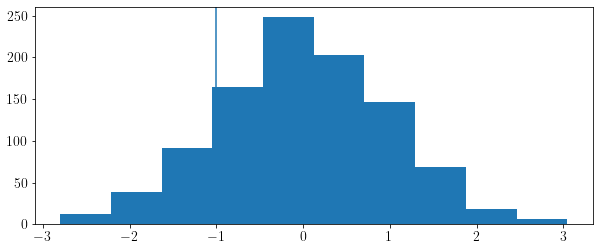

[-0.00049325]
[0.97322073]
[-1.23160099]


In [153]:
plot1 = plt.figure(1)
plt.subplot(1,1,1)
plt.hist(X[0,])
plt.axvline(x=x1)
#plt.subplot(1,2,2)
#plt.hist(X[1,])
plt.show()

print(np.mean(X, axis=1))
print(np.std(X, axis=1))
print(np.mean(D, axis=1))

## Update
We then use `subspace_ies` to update our prior.

In [154]:
Xi = subspace_ies(X, D, g, False, 0.5, 20)
print(np.mean(X, axis=1))
print(np.std(X, axis=1))
print(np.mean(Xi, axis=1))
print(np.std(Xi, axis=1))

Using projection matrix
[-0.00049325]
[0.97322073]
[-0.60736625]
[0.59431371]


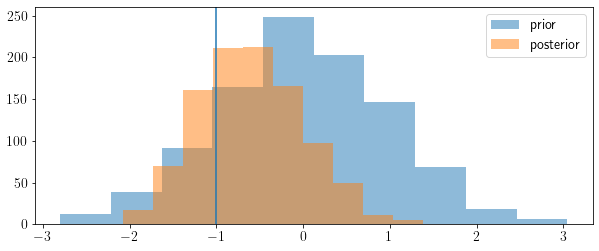

In [155]:
plot2 = plt.figure(2)
plt.subplot(1,1,1)
plt.hist(X[0,], alpha=0.5, label="prior")
plt.hist(Xi[0,], alpha=0.5, label="posterior")
plt.axvline(x=x1)
plt.legend(loc="upper right")
plt.show()

## Inspection of projection

Since the model is non-linear and parameter size is much smaller than ensemble size, the projection at Equation 28 is used, referring to the numerical solution of $S_i$ in Section 2.5. We inspect how this may affect the result, by directly inspecting the projection, but also calculating the update seemingly as if `g` was linear.

In [156]:
centering_matrix = (
    np.identity(realizations) - 
    np.ones((realizations,realizations))/realizations
)/np.sqrt(realizations-1)
gXi = np.array([g(parvec) for parvec in X.T]).reshape(1,realizations)
Y = gXi @ centering_matrix
A = X @ centering_matrix ## NB: Using Xi not X
projection_matrix = np.linalg.pinv(A) @ A
sjekk = Y @ projection_matrix

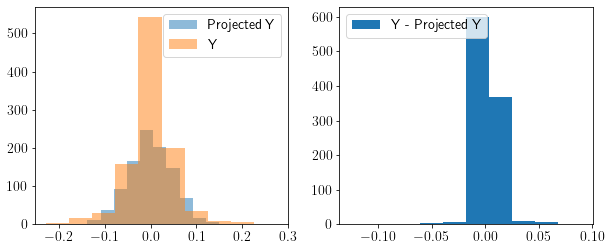

In [157]:
plot3 = plt.figure(3)
plt.subplot(1,2,1)
plt.hist(sjekk[0,], alpha=0.5, label="Projected Y")
plt.hist(Y[0,], alpha=0.5, label="Y")
plt.legend(loc="upper right")
plt.subplot(1,2,2)
plt.hist(sjekk[0,]-Y[0,], label="Y - Projected Y")
plt.legend(loc="upper left")
plt.show()

In [158]:
Xi2 = subspace_ies(X, D, g, True, 0.1, 100)
print(np.mean(X, axis=1))
print(np.std(X, axis=1))
print(np.mean(Xi, axis=1))
print(np.std(Xi, axis=1))
print(np.mean(Xi2, axis=1))
print(np.std(Xi2, axis=1))

[-0.00049325]
[0.97322073]
[-0.60736625]
[0.59431371]
[-0.61626354]
[0.59303905]


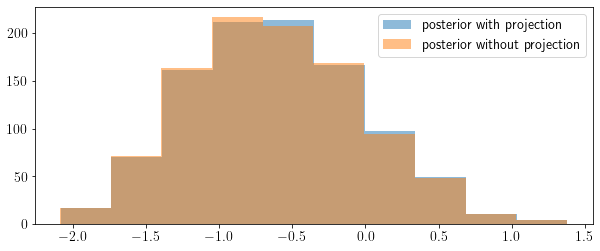

In [159]:
plot4 = plt.figure(3)
#plt.hist(X[0,], alpha=0.5, label="prior")
plt.hist(Xi[0,], alpha=0.5, label="posterior with projection")
plt.hist(Xi2[0,], alpha=0.5, label="posterior without projection")
#plt.axvline(x=x1)
plt.legend(loc="upper right")
plt.show()

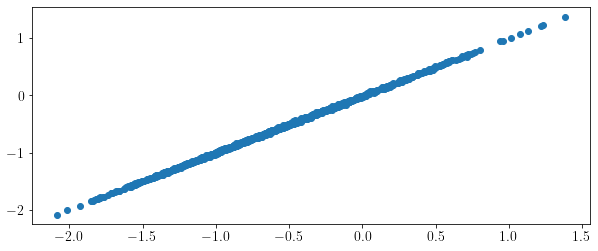

In [160]:
plot5 = plt.figure(5)
plt.scatter(Xi[0,],Xi2[0,])
plt.show()

# Example 5.2: Verification on ERT Poly Case

The model is a 2'nd degree polynomial.
Note that it is written in terms of coefficients $\bf{x}$

$$
y = g(x;z) = x_1z^2 + x_2z + x_3.
$$


### Forward model definition

In [188]:
def poly(x, z):
    a, b, c = x[0], x[1], x[2]
    return a*z**2 + b*z + c

### Generate observations

We generate observations at `z=[0,2,4,6,8].T`, thus `m=5`.

In [189]:
a_t = 0.5
b_t = 1.0
c_t = 3.0
x = np.array([a_t, b_t, c_t])
n = x.shape[0]
z_observations = [0, 2, 4, 6, 8]
observations = [
    (
        poly(x, z) + rng.normal(loc=0, scale=0.2 * poly(x, z)),
        0.2 * poly(x, z),
        z,
    )
    for z in z_observations
]
d = pd.DataFrame(observations, columns=["value", "sd", "z"])
d = d.set_index("z")
m = d.shape[0]

### Generate prior

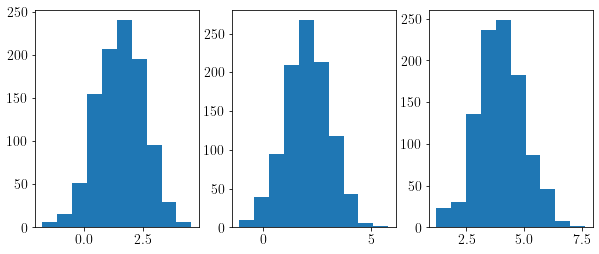

In [190]:
# Generate data
rng = np.random.default_rng(12345)
N = 1000
# sample x
x_sd = np.array([1.0, 1.0, 1.0])
bias = 1
X = np.array(
    [np.random.normal(xi+bias, xi_sd, size=(1,N)) for xi, xi_sd in zip(x, x_sd)]
).reshape(n, N)

plot6 = plt.figure(6)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.hist(X[i,])
plt.show()

### Perturbed observations

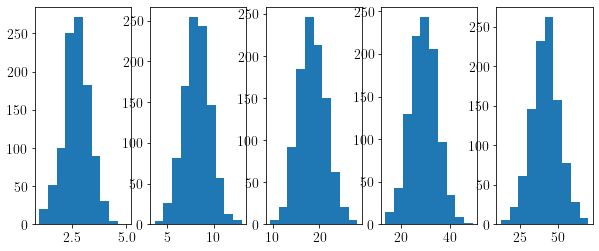

In [191]:
Cdd = np.diag(d.sd.values**2)
E = rng.multivariate_normal(mean=np.zeros(m), cov=Cdd, size=N).T
#E = E - E.mean(axis=1, keepdims=True)
D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

plot7 = plt.figure(7)
for i in range(m):
    plt.subplot(1,m,i+1)
    plt.hist(D[i,])
plt.show()

## Update
We then use `subspace_ies` to update our prior.
We need to let our forward model `poly` be a function only of parameters `x` and not `z` values.
Define `g: R^n -> R^m` evaluated over the `m` `z`-values

In [192]:
g = lambda x: [poly(x, zi) for zi in z_observations]

In [193]:
Xi = subspace_ies(X, D, g, False, 0.3, 30)
print(np.mean(X, axis=1))
print(np.std(X, axis=1))
print(np.mean(Xi, axis=1))
print(np.std(Xi, axis=1))

Using projection matrix
[1.52363378 2.02032178 3.99334929]
[0.99200219 1.03173267 1.00147183]
[0.42164785 1.90438195 3.02086605]
[0.16053473 0.71652433 0.50839569]


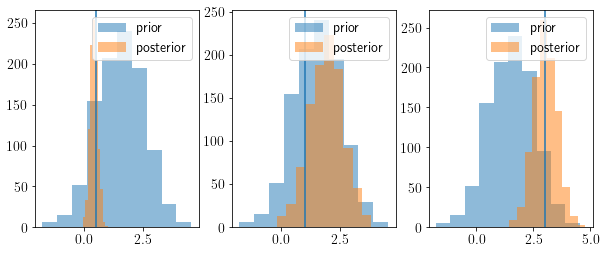

In [194]:
posterior_plot = plt.figure()
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.hist(X[0,], alpha=0.5, label="prior")
    plt.hist(Xi[i,], alpha=0.5, label="posterior")
    plt.axvline(x=x[i])
    plt.legend(loc="upper right")
plt.show()

# Example 3: Highly Non-Linear Oscilator

### Forward model definition

Base on example here:  https://github.com/dafeda/iterative_ensemble_smoother/blob/oscillator/docs/source/Oscillator.py

###   Generate observations

### Generate prior

### Perturb observations

### Update